**Part 1 : Miscellaneous**

In [77]:
#Installations

#!pip install emoji
#!pip install nltk
#!pip install transformers
#!pip install torch
#!pip install sentence_transformers
#!pip install textblob
#!pip install keras
#!pip install tensorflow

In [78]:
#Environment details
import platform
import sys

# Python version
python_version = platform.python_version()

# Operating system
os_name = platform.system()
os_version = platform.version()

# Computer details
machine = platform.machine()

# Display information
print(f"Python Version: {python_version}")
print(f"Operating System: {os_name} {os_version}")
print(f"Machine: {machine}")


Python Version: 3.11.5
Operating System: Windows 10.0.22631
Machine: AMD64


In [79]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import emoji
import random
import string
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from textblob import TextBlob
import itertools
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
from transformers import BertweetTokenizer, RobertaModel
import torch
from transformers import RobertaConfig
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding

import warnings
warnings.filterwarnings("ignore")

**Part 2 : Loading Dataset**

In [80]:
#Loading the dataset
path = os.getcwd()
dataset_path = path + '/dataset'
dfs = []
for i,fname in enumerate(os.listdir(dataset_path)):
    if fname.endswith('.xlsx'):
        file_path = os.path.join(dataset_path, fname)
        df = pd.read_excel(file_path)
        dfs.append(df)
df = pd.concat(dfs,ignore_index=True)
df.head()

,question,reply,replies_count,up_counts,relevance_rating
0,What is THE best question to ask on a job inte...,One that has always gone over well for me:\n\n...,7,1047,9.0
1,What is THE best question to ask on a job inte...,"When you were interviewing here, what would yo...",9,2625,6.0
2,What is THE best question to ask on a job inte...,Ask them what is the biggest problem you can s...,9,1669,7.0
3,What is THE best question to ask on a job inte...,A question that landed me a job once was:\n“If...,6,712,8.0
4,What is THE best question to ask on a job inte...,I like to ask:\n\n1. How is success measured i...,6,593,7.0


In [81]:
df.shape

(7938, 5)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7938 non-null   object 
 1   reply             7937 non-null   object 
 2   replies_count     7938 non-null   int64  
 3   up_counts         7938 non-null   int64  
 4   relevance_rating  4832 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 310.2+ KB


**Part 3 : Basic Preprocessing**

In [83]:
df.rename(columns={'reply': 'comment'}, inplace=True)
df.rename(columns={'up_counts': 'score'}, inplace=True)

In [84]:
#Dropping the records with no reply.
df = df.dropna(subset=['comment'])

In [85]:
#Drop duplicate records.
df.drop_duplicates(subset=['question', 'comment'], keep='first', inplace=True)

In [86]:
#Dropping the records which are deleted/removed posts.
invalid_posts = ['[deleted]','[removed]']
df = df[~df['comment'].isin(invalid_posts)]

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [88]:
#Cleaning the comment data.
def clean_text(text):
    #Removing the attached urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)
    #Replacing the \n with spaces
    text = text.replace('\n', ' ')
    #Removing the extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    #Removing the emojis
    text = emoji.demojize(text)
    return text
df['comment'] = df['comment'].apply(clean_text)

In [89]:
print(df.sample(n=5))

                                               question  \
894   What do y’all think is the Best iphone 15 pro ...   
189   What is THE best question to ask on a job inte...   
1760              Is Youtube music better than Spotify?   
5530  What is a Pokemon you love that isn't very pop...   
3842  What is a Pokemon you love that isn't very pop...   

                                                comment  replies_count  score  \
894       Doesnt matter, im putting an otter box on it.              0      2   
189   If you're expected to ask questions then have ...              0      1   
1760     Couldn't you just make another YouTube account              0      3   
5530  Rock and grass cancel out a lot of each other'...              1     11   
3842                                         Jellicent!              0      1   

      relevance_rating  
894                1.0  
189                7.0  
1760               1.0  
5530               2.0  
3842               NaN  


In [90]:
#Checking the target.
df['relevance_rating'].value_counts()

relevance_rating
1.0     992
6.0     840
7.0     595
8.0     587
9.0     417
10.0    357
3.0     225
5.0     214
2.0     212
4.0     156
0.0      74
Name: count, dtype: int64

There are null values and 0 as well when the considered scale is from 1-10.

In [91]:
#replacing the 0s with 1s
df['relevance_rating'] = df['relevance_rating'].replace(0.0, 1.0)
df['relevance_rating'].value_counts()

relevance_rating
1.0     1066
6.0      840
7.0      595
8.0      587
9.0      417
10.0     357
3.0      225
5.0      214
2.0      212
4.0      156
Name: count, dtype: int64

Imbalanced data based on the relevance_ratings.

**Part 4 : Visualizations**

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [93]:
#Shuffling the records.
df = df.sample(frac=1).reset_index(drop=True)

In [94]:
df.describe()

,replies_count,score,relevance_rating
count,7571.000000,7571.000000,4669.000000
mean,0.433100,11.222956,5.372242
std,1.451773,77.151973,3.051719
min,0.000000,-62.000000,1.000000
25%,0.000000,1.000000,2.000000
50%,0.000000,1.000000,6.000000
75%,0.000000,3.000000,8.000000
max,54.000000,2916.000000,10.000000


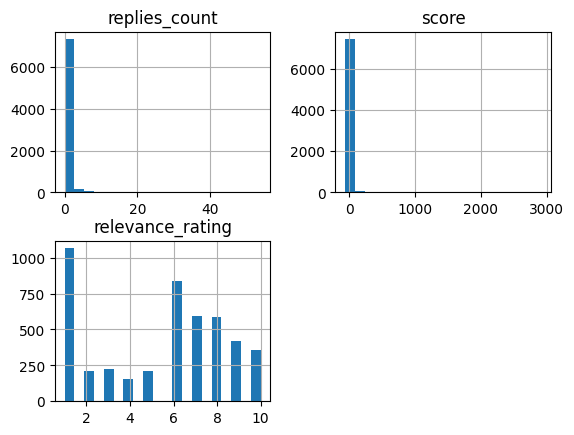

In [95]:
#Continuous values 
df.hist(bins = 20)
plt.show()

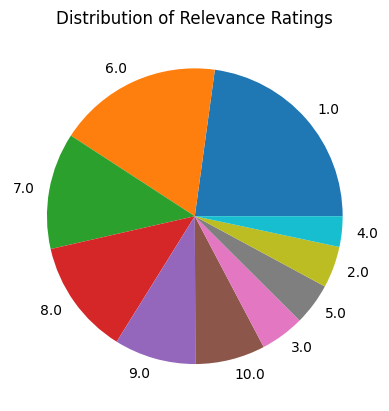

In [96]:
df['relevance_rating'].value_counts().plot.pie()
plt.title('Distribution of Relevance Ratings')
plt.ylabel('')
plt.show()

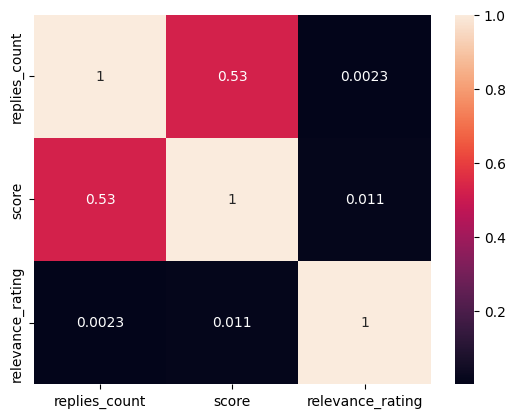

In [97]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

In [98]:
#Just for visualization:
df['question'].value_counts()

question
What is a Pokemon you love that isn't very popular or talked about?        2491
What is your favourite game of all time                                    1251
What do y’all think is the Best iphone 15 pro max color?                    898
Which cities in America is baseball more popular than football?             888
What is THE best question to ask on a job interview?                        671
Most job interviews are harder than the job itself                          344
Anyone else feel like LinkedIn is overrated to job searching?               330
What are your favorite gadgets that make life just a little bit easier?     259
What's YOUR favourite food?                                                 205
Is Youtube music better than Spotify?                                       134
Is baseball poorly designed?                                                100
Name: count, dtype: int64

In [99]:
label_encoder = LabelEncoder()
df_question_encoded = df.copy()
df_question_encoded['question'] = label_encoder.fit_transform(df_question_encoded['question'])

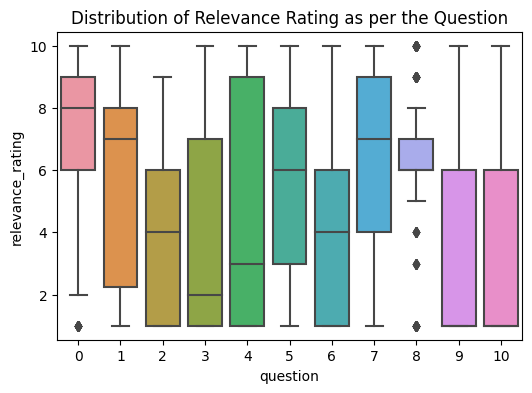

In [100]:
#Distribution of relevance_rating as per the questions.
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_question_encoded, x='question', y='relevance_rating')
plt.title('Distribution of Relevance Rating as per the Question')
plt.show()

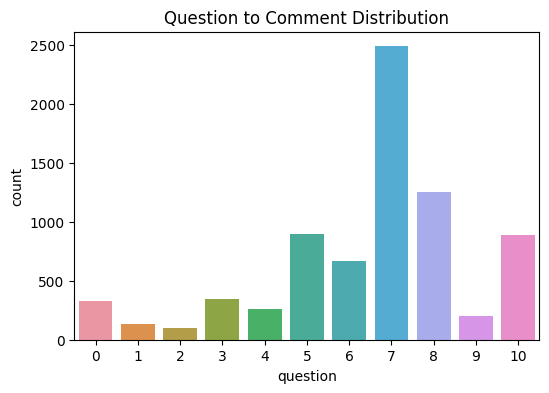

In [101]:
#Distribution of comments as per questions.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_question_encoded, x='question')
plt.title('Question to Comment Distribution')
plt.show()

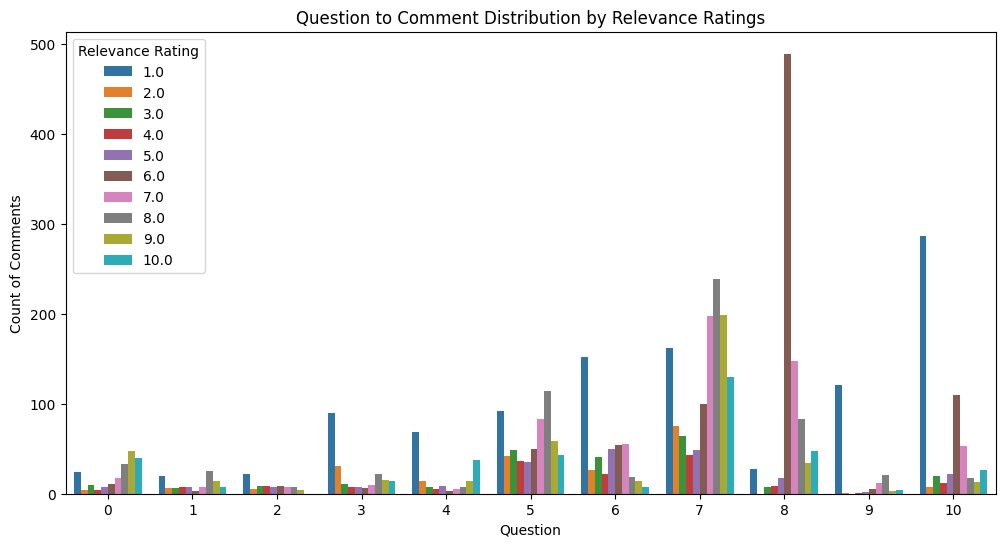

In [102]:
#Question to Comment Distribution divided by Relevance Ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_question_encoded, x='question', hue='relevance_rating')
plt.title('Question to Comment Distribution by Relevance Ratings')
plt.xlabel('Question')
plt.ylabel('Count of Comments')
plt.legend(title='Relevance Rating')
plt.show()

**Part 5 : Constructing our metric to calculate relevance as better as possible**

This is all good and fine but in the end how do we find which answers are with good relevance and which are not? <br>
To acheive this, we need to consider various factors like :
1. The semantic similarity of the comment to the question
2. The syntax match of comment to the question
3. The polarity of the comment
4. If we consider clusters, then the coherence factor
5. User engagement factors (like upvotes/downvotes)
6. Temporal relevance (timestamp factor)
7. diversity of perspectives
8. spam/irrelevant content detection in here as well

In [103]:
def calculate_sentiment_probabilities(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
    
def calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings):
    return cosine_similarity(question_embedding,cluster_comment_embeddings)
    
def calculate_cluster_coherence_tfidf(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    cluster_comment_embeddings_arr = np.array([comment[0] for comment in cluster_comment_embeddings])
    print(cluster_comment_embeddings_arr)
    print(cluster_comment_embeddings_arr.shape)
    if len(cluster_comment_embeddings_arr.shape) > 2:
        cluster_comment_embeddings_arr = cluster_comment_embeddings_arr.reshape(cluster_comment_embeddings_arr.shape[0], -1)
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings_arr)
    coherence = np.mean(pairwise_similarity)
    similarity = calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings_arr)
    return (coherence,similarity)
    
def calculate_cluster_coherence_lda(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    cluster_comment_embeddings_arr = np.array(cluster_comment_embeddings)
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings_arr)
    coherence = np.mean(pairwise_similarity)
    similarity = calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings_arr)
    return (coherence,similarity)
    
def calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings):
    return cosine_similarity([question_embedding],cluster_comment_embeddings)[0]

def calculate_cluster_coherence_pre_trained(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings)
    coherence = np.mean(list(itertools.chain.from_iterable(pairwise_similarity)))
    similarity = calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings)
    return (coherence,similarity)

def calculate_relevance_scores(df, question_embedding,cluster_embeddings, topics, mode):
    relevance_scores = []
    
    for key,cluster_comments in topics.items():
        # Extracting the comments in this cluster
        df_temp = df[df['comment'].isin(cluster_comments)]
        
        # User engagement factors: score and reply counts
        max_score = max(df_temp['score'])
        min_score = min(df_temp['score'])
        normalized_scores = [(s - min_score) / (max_score - min_score) for s in df_temp['score']]
        
        max_replies = max(df_temp['replies_count'])
        min_replies = min(df_temp['replies_count'])
        normalized_replies = [(count - min_replies) / (max_replies - min_replies) for count in df_temp['replies_count']]
        
        # Cluster coherence,semantic similarity
        coherence,semantic_similarity = eval('calculate_cluster_coherence_' + mode)(question_embedding,cluster_embeddings,key)
        
        # Sentiment polarity of each comment
        sentiments = [calculate_sentiment_probabilities(comment) for comment in cluster_comments]
        max_sentiment = max(sentiments)
        min_sentiment = min(sentiments)
        normalized_sentiment = [(sentiment - min_sentiment) / (max_sentiment - min_sentiment) for sentiment in sentiments]

        # Calculate relevance score for the current cluster
        relevance_score = np.mean(normalized_scores) + np.mean(normalized_replies) + np.mean(normalized_sentiment) + np.mean(semantic_similarity) + coherence        
        relevance_scores.append((str(key),relevance_score))
        
    relevances = [r for _, r in relevance_scores]
    max_relevance = max(relevances)
    min_relevance = min(relevances)
    normalized_relevances = [(relevance - min_relevance) / (max_relevance - min_relevance) for relevance in relevances]
    
    # Create a dictionary with comments as keys and normalized sentiments as values
    relevance_scores = dict(zip(topics.keys(), normalized_relevances))
    return relevance_scores

**Part 6 : Getting into models**

Tried going the supervised way but giving accurate labelling to the posts on our own was kind of stiffling and we tried semi supervised way to give lables to the rest of the data by using label propogation - not very good results. <br>
Check the file : Initial working - Label propogation.ipynb in the same folder. <br>
Hence we are dabbling with unsupervised way now : 

Well ultimately what we need to do is to assign proper weights/embeddings to the words in the sentence so that the similarity metrics later used will provide good outputs. <br>
So the process flow is :
- consider an algorithm/model to assign weights to the sentences i.e, the approach is to create a complex model where the input is a string, and the output is a representation of the word or sentence (called embedding) and these embeddings should accurately represent the syntax and semantic.
- then use a similarity/distance metric among the embeddings to give a number!
- We can also use correlation coefficients i guess (lets check)

Some context for this : there are multiple ways to provide an embedding:<br>
1. Using simple similarity metrics like - cosine similiarity, Word Mover's Distance, Levenshtein distance, Hamming distance etc.
2. Using Word Embeddings (Spacy,bag-of-words,tf-idf,smooth inverse frequency)
3. Word2Vec or Doc2Vec
4. Pre-trained encoders (Transfer learning)
5. Bert embeddings
6. OpenAI
7. Siamese Networks? - needs labelling itseems
8. Semantic matching techniques ?
9. Transformers using attention mechanism

But the above points are all good for finding the syntax and similarity. How about contextual relevance then? <br>
Possible options for us to try would be : 
- Pre-trained models like bert and gpt
- Siamese networks
- Semantic matching models

I am going to use all of these and also in combinations (hybrid models).

 - <strong>Tf-Idf with Nearest neighbors</strong>

In [104]:
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    clean_text = re.sub(pattern, '', text)    
    return clean_text
    
#Not using this for now!
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop])

df['comment'] = df['comment'].apply(remove_special_characters).str.lower()
df['question'] = df['question'].apply(remove_special_characters).str.lower()
df.head()

[nltk_data] Downloading package stopwords to C:\Users\Vineetha
[nltk_data]     Maddikunta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question,comment,replies_count,score,relevance_rating
0,which cities in america is baseball more popul...,louisville,1,1,6.0
1,what do yall think is the best iphone 15 pro m...,i think im hypnotized to like natural titanium...,0,1,1.0
2,what is your favourite game of all time,favorite game that i have played is wild of th...,0,1,7.0
3,which cities in america is baseball more popul...,fun fact rutgers only national championship wa...,1,5,NaN
4,what is your favourite game of all time,the original zelda closely now followed by eld...,0,1,10.0


Lets check the basic similarities between the question and replies and among replies as well.

In [105]:
question1df = df[df['question'] == df['question'][0]]

question = question1df['question'][0]
comments = question1df['comment'].to_numpy(dtype='object')

In [106]:
vectorizer = TfidfVectorizer()
comment_vectors = vectorizer.fit_transform(question1df['comment'])
question_vectors = vectorizer.transform(question1df['question'])

# Compute pairwise cosine similarity between sentence vectors
cosine_similarities = cosine_similarity(comment_vectors)
cosine_similarities_qv = cosine_similarity(comment_vectors, question_vectors)

# Print cosine similarity matrix
print("Cosine Similarity Matrix:")
print(pd.DataFrame(cosine_similarities))

Cosine Similarity Matrix:
     0         1         2         3         4         5         6    \
0    1.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.0  1.000000  0.034502  0.065582  0.093116  0.000000  0.000000   
2    0.0  0.034502  1.000000  0.160757  0.235236  0.000000  0.022724   
3    0.0  0.065582  0.160757  1.000000  0.192865  0.000000  0.012857   
4    0.0  0.093116  0.235236  0.192865  1.000000  0.011816  0.047734   
..   ...       ...       ...       ...       ...       ...       ...   
883  0.0  0.016545  0.024867  0.010861  0.046697  0.000000  0.047475   
884  0.0  0.011037  0.022121  0.067439  0.069720  0.038360  0.023344   
885  0.0  0.013126  0.048548  0.045768  0.084041  0.000000  0.000000   
886  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
887  0.0  0.043520  0.062049  0.025445  0.050974  0.000000  0.022358   

          7    8         9    ...       878       879       880       881  \
0    0.000000  0.0  0.000000  ..

In [107]:
def get_top_similar_pairs(cosine_similarity_matrix):
    num_records = cosine_similarity_matrix.shape[0]
    pairs = []

    # Iterate through upper triangle of similarity matrix
    for i in range(num_records):
        for j in range(i+1, num_records):
            pairs.append(((i, j), cosine_similarity_matrix[i, j]))

    # Sort pairs by similarity score in descending order
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs

top_n = 5
top_similar_pairs = get_top_similar_pairs(cosine_similarities)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (11, 833) Similarity Score: 1.0000000000000002
los angeles 
and
 los angeles
--------------------------------------
Pair: (226, 538) Similarity Score: 1.0000000000000002
can confirm 
and
 can confirm
--------------------------------------
Pair: (322, 357) Similarity Score: 1.0000000000000002
there are not enough bad things that can happen to stan kroenke 
and
 there are not enough bad things that can happen to stan kroenke
--------------------------------------
Pair: (511, 880) Similarity Score: 1.0000000000000002
st louis for sure 
and
 st louis for sure
--------------------------------------
Pair: (41, 636) Similarity Score: 1.0
atlanta 
and
 atlanta
--------------------------------------


In [108]:
top_similar_pairs = get_top_similar_pairs(cosine_similarities_qv)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (634, 635) Similarity Score: 0.4995340778230193
outside of usa probably baseball is more popular than football in most other countries and all their cities im not sure south america cares much about american football the countries in central america def are more baseball canada def is more into baseball 
and
 man all these cities are busy though like we are comparing you to nyc and la right now
--------------------------------------
Pair: (634, 636) Similarity Score: 0.4995340778230193
outside of usa probably baseball is more popular than football in most other countries and all their cities im not sure south america cares much about american football the countries in central america def are more baseball canada def is more into baseball 
and
 atlanta
--------------------------------------
Pair: (634, 637) Similarity Score: 0.4995340778230193
outside of usa probably baseball is more popular than football in most other countries and all their cities im not sur

In [109]:
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
nn_model.fit(comment_vectors.toarray())

# Query the model to find the most similar sentence to the first sentence
query_vec = vectorizer.transform([' '.join(df['question'][0])])
distances, indices = nn_model.kneighbors(query_vec.toarray(), return_distance=True)

# Print the most similar sentence
print(indices)
print("Most similar sentence to '{}'".format(df['question'][0]))
for i in indices[0]:
    print(question1df.iloc[i]['comment'])
    print("\n")

[[591 589 594 593 592 596]]
Most similar sentence to 'which cities in america is baseball more popular than football'
wait really i always thought that the chargers were usually bigger than the padres when they were still down there


as someone whos a fan of 34 of the boston teams yankees have just been my familys team for decades its pretty balanced across the 4 sports right now even the bruins are getting love and nhl teams are usually forgotten in multi sport markets


fuck kroenke indeed what a slime ball


la didnt build it either stan could have chosen to stay in stl and build sofi in stl probably for a fraction of the price no the team wouldnt be worth more in stl but he wouldnt be going broke either plenty of owners find themselves happy in smaller markets than la and he was the reason stl did not get an expansion team in the early 90s and then team up with georgia to bring the rams to stl he is conning everyone


which type of football in atlanta id say braves over falcons bu

In [110]:
num_topics = 5  
kmeans_tfidf = KMeans(n_clusters=num_topics)
kmeans_tfidf.fit(comment_vectors)

# Assign each comment to a cluster
cluster_labels_tfidf = kmeans_tfidf.labels_

cluster_embeddings_tfidf = defaultdict(list)
for i, label in enumerate(cluster_labels_tfidf):
    cluster_embeddings_tfidf[label].append(comment_vectors[i])
cluster_embeddings_tfidf = dict(cluster_embeddings_tfidf)

# Print comments belonging to each cluster (topic)
topics_tfidf = {}
for i, comment in enumerate(comments):
    if cluster_labels_tfidf[i] not in topics_tfidf:
        topics_tfidf[cluster_labels_tfidf[i]] = []
    topics_tfidf[cluster_labels_tfidf[i]].append(comment)

In [111]:
filtered_data = {key: value[:4] for key, value in topics_tfidf.items()}
pd.DataFrame(filtered_data)

,0,2,4,1,3
0,louisville,people still liked and followed the giants but...,the blue jays are bigger than the argonauts,safe to say san diego,i always had the impression that when the char...
1,fun fact rutgers only national championship wa...,yep snyder bought the team in 99 and was obvio...,in my experience this is a college basketball ...,st louis fuck stan kronke,every other city changes depending on how thei...
2,dont worry i wouldnt pee on kroenkes grave,dude right after kroenke tool full control he ...,yeah id argue nyc mostly because the only time...,st louis and san diego apparently,junior seau ran sd but right after brees left ...
3,cincinnati used to love baseball,chicago is absolutely a football team just ask...,havent seen anyone offer milwaukee so ill toss...,st louis,rams went from a bottom 5 market value team to...


In [112]:
# relevance_scores_tfidf = calculate_relevance_scores(question1df,question_vectors,cluster_embeddings_tfidf,topics_tfidf,'tfidf')
# print("Relevance Scores for Each Cluster:", relevance_scores_tfidf)

- **Latent Dirichlet Allocation (LDA) for topic modeling**

In [113]:
# Vectorize the corpus using TF-IDF
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform([question] + comments)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(X)

# Transform question and comments to topic distributions
question_topic = lda_model.transform(vectorizer2.transform([question]))
comment_topics = lda_model.transform(vectorizer2.transform(comments))

# Calculate cosine similarity between question topic and comment topics
similarity_scores = cosine_similarity(question_topic, comment_topics)[0]

# Filter relevant comments based on semantic similarity
threshold = np.percentile(similarity_scores, 50)  # Adjust threshold as needed
relevant_comments = [(comment,score) for comment, score in zip(comments, similarity_scores)]
relevant_comments = sorted(relevant_comments, key=lambda x: x[1], reverse=True)
print("Question : ",question)
print("Relevant comments:")
for comment,score in relevant_comments:
    print("-", comment,score)

Question :  which cities in america is baseball more popular than football
Relevant comments:
- they def care more about the raiders than those two teams 0.9999999678461146
- yup that stadium was indeed very much red during the nfc title game 0.9999998625499735
- you live in a city where baseball is more popular than football lol 0.9999998538632667
- city of atlanta loves the falcons but the suburbs love the braves 0.9999998447297981
- sacramento most of the year but right now we are loving basketball 0.9999998235799387
- nah man as someone who lives in wisconsin it isnt an important place lol jk jk 0.9999998187590708
- this city wouldve celebrated the world series for approximately 1 hour before switching back to football mode 0.9999998024111474
- i mean if youre fortunate enough to have vin scully as your summers soundtrack for several generations who wouldnt 0.9999997907008806
- aint no way you saying more people go to rams games than dodgers games 0.9999996895577474
- lot of casual

Observations : 
1. Pretty accurate for correct ones but also classified a lot of correct ones as wrong ones.
2. Works good for small sentences but seems to be failing for longer sentences with more explanation.

In [114]:
num_topics = 5  
kmeans_lda = KMeans(n_clusters=num_topics)
kmeans_lda.fit(comment_topics)

# Assign each comment to a cluster
cluster_labels_lda = kmeans_lda.labels_

cluster_embeddings_lda = defaultdict(list)
for i, label in enumerate(cluster_labels_lda):
    cluster_embeddings_lda[label].append(comment_topics[i])
cluster_embeddings_lda = dict(cluster_embeddings_lda)

# Print comments belonging to each cluster (topic)
topics_lda = {}
for i, comment in enumerate(comments):
    if cluster_labels_lda[i] not in topics_lda:
        topics_lda[cluster_labels_lda[i]] = []
    topics_lda[cluster_labels_lda[i]].append(comment)

In [115]:
filtered_data = {key: value[:3] for key, value in topics_lda.items()}
pd.DataFrame(filtered_data)

,3,0,2,4,1
0,louisville,fun fact rutgers only national championship wa...,dont worry i wouldnt pee on kroenkes grave,definitely houston,nah
1,in 2018 the cleveland browns selected baker ma...,people still liked and followed the giants but...,cincinnati used to love baseball,los angeles,rfuckstankroenke
2,sadly and inexplicably not cleveland,yep snyder bought the team in 99 and was obvio...,you might be the first person to literally eve...,possibly la,yeah was sad to see the ducks struggling to fi...


In [116]:
relevance_scores_lda = calculate_relevance_scores(question1df,question_topic,cluster_embeddings_lda,topics_lda,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_lda)

Relevance Scores for Each Cluster: {3: 0.07648067320861571, 0: 1.0, 2: 0.6924743813010907, 4: 0.31381174833144326, 1: 0.0}


- **Pre-trained models** (Transfer Learning)

In [117]:
model = SentenceTransformer('paraphrase-distilroberta-base-v2')
comment_embeddings = model.encode(comments)
question_embedding = model.encode(question)
num_topics = 5  
kmeans = KMeans(n_clusters=num_topics)
kmeans.fit(comment_embeddings)

# Assign each comment to a cluster
cluster_labels = kmeans.labels_

cluster_embeddings = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings):
    cluster_label = cluster_labels[i]
    cluster_embeddings[cluster_label].append(comment_embedding)
cluster_embeddings = dict(cluster_embeddings)
# Print comments belonging to each cluster (topic)
topics = {}
for i, comment in enumerate(comments):
    if cluster_labels[i] not in topics:
        topics[cluster_labels[i]] = []
    topics[cluster_labels[i]].append(comment)

In [118]:
filtered_data = {key: value[:4] for key, value in topics.items()}
pd.DataFrame(filtered_data)

,4,0,3,2,1
0,louisville,fun fact rutgers only national championship wa...,people still liked and followed the giants but...,dude right after kroenke tool full control he ...,definitely houston
1,los angeles,cincinnati used to love baseball,yep snyder bought the team in 99 and was obvio...,dont worry i wouldnt pee on kroenkes grave,sadly and inexplicably not cleveland
2,possibly la,it would be interesting to see a city by city ...,chicago is absolutely a football team just ask...,nah,and milwaukee is two hours away from green bay...
3,st louis fuck stan kronke,in my experience this is a college basketball ...,new york city yankees run it and the only one ...,you might be the first person to literally eve...,safe to say san diego


In [119]:
relevance_scores = calculate_relevance_scores(question1df,question_embedding,cluster_embeddings,topics,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores)

Relevance Scores for Each Cluster: {4: 0.5812890787724563, 0: 1.0, 3: 0.8807219599322094, 2: 0.0, 1: 0.3809603500801047}


- **Pre-trained models (Another version or Bert)**

In [120]:
comments.shape

(888,)

In [121]:
model2 = SentenceTransformer('vinai/bertweet-base', device='cpu') 
comment_embeddings_m2 = []
for comment in comments:
    if len(comment) > model2.max_seq_length:
       comment = comment[:model2.max_seq_length]
    comment_embedding = model2.encode(comment)
    comment_embeddings_m2.append(torch.from_numpy(comment_embedding))
comment_embeddings_m2 = torch.stack(comment_embeddings_m2)
question_embedding_m2 = model2.encode(question)

num_topics = 5  
kmeans2 = KMeans(n_clusters=num_topics)
kmeans2.fit(comment_embeddings_m2)
cluster_labels_m2 = kmeans2.labels_

cluster_embeddings_m2 = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_m2):
    cluster_label = cluster_labels_m2[i]
    cluster_embeddings_m2[cluster_label].append(comment_embedding)
cluster_embeddings_m2 = dict(cluster_embeddings_m2)

topics2 = {}
for i, comment in enumerate(comments):
    if cluster_labels_m2[i] not in topics2:
        topics2[cluster_labels_m2[i]] = []
    topics2[cluster_labels_m2[i]].append(comment)

No sentence-transformers model found with name vinai/bertweet-base. Creating a new one with MEAN pooling.


In [122]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,3,4,2,1,0
0,louisville,fun fact rutgers only national championship wa...,dont worry i wouldnt pee on kroenkes grave,chicago is absolutely a football team just ask...,sadly and inexplicably not cleveland
1,definitely houston,people still liked and followed the giants but...,cincinnati used to love baseball,new york city yankees run it and the only one ...,came here to comment this in the same vein san...
2,los angeles,yep snyder bought the team in 99 and was obvio...,in 2018 the cleveland browns selected baker ma...,to be fair those 6a hs teams could probably be...,rfuckstankroenke
3,nah,dude right after kroenke tool full control he ...,safe to say san diego,which is kind of funny because the white sox c...,houstonright edit i didnt mean to post twice


In [123]:
relevance_scores_m2 = calculate_relevance_scores(question1df,question_embedding_m2,cluster_embeddings_m2,topics2,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores_m2)

Relevance Scores for Each Cluster: {3: 0.0, 4: 1.0, 2: 0.26289366304990286, 1: 0.7446963384000314, 0: 0.32484103290447947}


- **LSTM model**

In [124]:
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts(comments)
sequences = tokenizer_lstm.texts_to_sequences(comments)
vocab_size = len(tokenizer_lstm.word_index) + 1 
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Model hyperparameters
embedding_dim = 50 
# Define the model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_lstm.add(LSTM(units=64))

# Compile the model (not necessary if you're not training)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Get embeddings
comment_embeddings_lstm = model_lstm.predict(padded_sequences)

28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step


In [125]:
tokenizer_lstm.fit_on_texts([question])
sequence = tokenizer_lstm.texts_to_sequences([question])
vocab_size = len(tokenizer_lstm.word_index) + 1
max_sequence_length = len(sequence[0])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
question_embeddings_lstm = model_lstm.predict(padded_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


In [127]:
num_topics = 5  
kmeans_lstm = KMeans(n_clusters=num_topics)
kmeans_lstm.fit(comment_embeddings_lstm)

# Assign each comment to a cluster
cluster_labels_lstm = kmeans_lstm.labels_

cluster_embeddings_lstm = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_lstm):
    cluster_label = cluster_labels_lstm[i]
    cluster_embeddings_lstm[cluster_label].append(comment_embedding)
cluster_embeddings_lstm = dict(cluster_embeddings_lstm)

# Print comments belonging to each cluster (topic)
topics_lstm = {}
for i, comment in enumerate(comments):
    if cluster_labels_lstm[i] not in topics_lstm:
        topics_lstm[cluster_labels_lstm[i]] = []
    topics_lstm[cluster_labels_lstm[i]].append(comment)

In [128]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,3,4,2,1,0
0,louisville,fun fact rutgers only national championship wa...,dont worry i wouldnt pee on kroenkes grave,chicago is absolutely a football team just ask...,sadly and inexplicably not cleveland
1,definitely houston,people still liked and followed the giants but...,cincinnati used to love baseball,new york city yankees run it and the only one ...,came here to comment this in the same vein san...
2,los angeles,yep snyder bought the team in 99 and was obvio...,in 2018 the cleveland browns selected baker ma...,to be fair those 6a hs teams could probably be...,rfuckstankroenke
3,nah,dude right after kroenke tool full control he ...,safe to say san diego,which is kind of funny because the white sox c...,houstonright edit i didnt mean to post twice


In [129]:
relevance_scores_lstm = calculate_relevance_scores(question1df,question_embeddings_lstm,cluster_embeddings_lstm,topics_lstm,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_lstm)

Relevance Scores for Each Cluster: {1: 1.0, 3: 0.16102918238291017, 0: 0.42652289531527454, 2: 0.0, 4: 0.4871979581103311}
